# Extract relations from SemEval 2010 Task 8 using a traditional machine learning-based approach

## 1.Install Required Packages

In [1]:
!pip install nltk
!pip install textblob
import nltk
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from textblob import TextBlob
import requests
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('words')
stop_words = stopwords.words('english')
words = set(nltk.corpus.words.words())
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. File path

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#path_to_test_file = "/content/gdrive/MyDrive/TEST_FILE.TXT"
#path_to_file = "/content/gdrive/MyDrive/TRAIN_FILE.TXT"
path_to_test_file = "./TEST_FILE.txt"
path_to_file = "./TRAIN_FILE.txt"

## 3.Load data

In [3]:
def load_data_label(path):
    """
    Load data and labels from a specified file path for relation extraction tasks.

    This function reads a file from the given path, where each data instance is
    expected to occupy four lines: the first line contains the ID and the sentence
    with entities marked, the second line specifies the relation, and the third and
    fourth lines are ignored. Entities within sentences are annotated with <e1> and
    <e2> tags.

    The function processes the sentences by replacing entity markers with special
    tokens, tokenizes sentences, removes the special tokens, finds the position of
    each entity within the tokenized list, and finally compiles a DataFrame with
    IDs, processed sentences, entity positions, entity texts, and relation labels.

    Arguments:
    - path: A string representing the file path of the dataset to be loaded.

    Returns:
    - df: A pandas DataFrame containing the processed dataset. The DataFrame includes
          columns for ID, sentence (with entities replaced by their respective placeholders),
          positions of the first and second entities, texts of the entities, and the
          numerical labels for the relations based on a predefined mapping.
    """

    temp_data = []
    lines = [line.strip() for line in open(path)]
    for idx in range(0, len(lines), 4):
        id = lines[idx].split("\t")[0]
        relation = lines[idx + 1]

        sentence = lines[idx].split("\t")[1][1:-1]
        sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
        sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
        sentence = sentence.replace("<e1>", "<e1> ").replace("</e1>", " </e11>")
        sentence = sentence.replace("<e2>", "<e2> ").replace("</e2>", " </e22>")

        tokens = nltk.word_tokenize(sentence)

        tokens.remove('_/e1_')
        tokens.remove('_/e2_')

        e1 = tokens.index("_e1_")
        del tokens[e1]
        element1=tokens[e1]
        e2 = tokens.index("_e2_")
        del tokens[e2]
        element2=tokens[e2]
        sentence = " ".join(tokens)
        temp_data.append([id, sentence, e1, element1, e2, element2, relation])

    df = pd.DataFrame(data=temp_data, columns=["id", "sentence", "e1_position","element1", "e2_position","element2", "class"])
    labelsMapping = {'Other': 0,'Message-Topic(e1,e2)': 1, 'Message-Topic(e2,e1)': 2,
                    'Product-Producer(e1,e2)': 3, 'Product-Producer(e2,e1)': 4,
                    'Instrument-Agency(e1,e2)': 5, 'Instrument-Agency(e2,e1)': 6,
                    'Entity-Destination(e1,e2)': 7, 'Entity-Destination(e2,e1)': 8,
                    'Cause-Effect(e1,e2)': 9, 'Cause-Effect(e2,e1)': 10,
                    'Component-Whole(e1,e2)': 11, 'Component-Whole(e2,e1)': 12,
                    'Entity-Origin(e1,e2)': 13, 'Entity-Origin(e2,e1)': 14,
                    'Member-Collection(e1,e2)': 15, 'Member-Collection(e2,e1)': 16,
                    'Content-Container(e1,e2)': 17, 'Content-Container(e2,e1)': 18}
    df['tag'] = [labelsMapping[r] for r in df['class']]
    x_sentence = df['sentence'].tolist()

    # Label Data
    y = df['tag']
    return df

In [4]:
df=load_data_label(path_to_file)
df_test = load_data_label(path_to_test_file)
df

,id,sentence,e1_position,element1,e2_position,element2,class,tag
0,1,The system as described above has its greatest...,12,configuration,15,elements,"Component-Whole(e2,e1)",12
1,2,The child was carefully wrapped and bound into...,1,child,9,cradle,Other,0
2,3,The author of a keygen uses a disassembler to ...,1,author,7,disassembler,"Instrument-Agency(e2,e1)",6
3,4,A misty ridge uprises from the surge .,2,ridge,6,surge,Other,0
4,5,The student association is the voice of the un...,1,student,2,association,"Member-Collection(e1,e2)",15
...,...,...,...,...,...,...,...,...
7995,7996,"When the notice is sent by fax , the notice is...",2,notice,6,fax,Other,0
7996,7997,The herbicide is derived from a natural antibi...,1,herbicide,7,antibiotic,"Entity-Origin(e1,e2)",13
7997,7998,"To test this , we placed a kitchen match in th...",8,match,11,jar,"Entity-Destination(e1,e2)",7
7998,7999,The farmers and city officials in the region h...,17,farmers,18,market,Other,0


<Axes: >

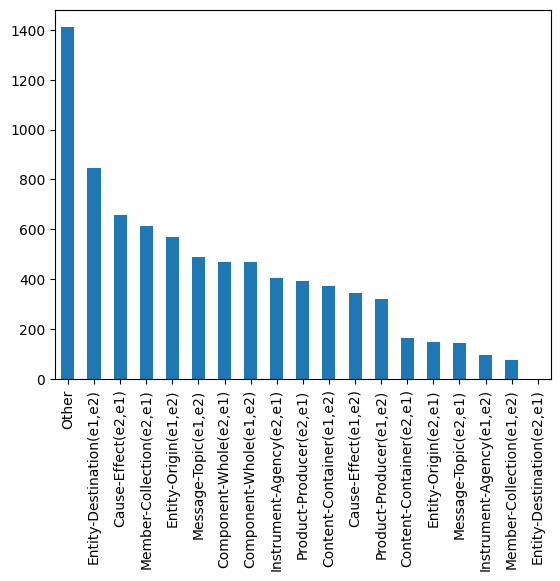

In [5]:
df['class'].value_counts()[:27].plot(kind='bar')

<Axes: >

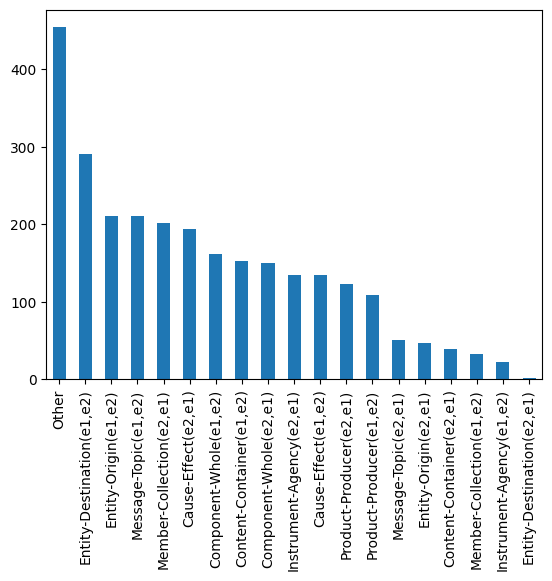

In [6]:
df_test['class'].value_counts()[:27].plot(kind='bar')

## 4.Preprocess data

In [7]:
def preprocess_sentence(sentence):
    """
    Preprocess a given sentence to prepare it for NLP tasks.

    This function performs several preprocessing steps on the input sentence:
    1. Removes usernames (mentions), special characters (excluding alphanumeric characters
       and spaces), URLs, and leading "rt" strings often found in tweets.
    2. Converts the sentence to lowercase to standardize the text.
    3. bu

    The preprocessing steps are designed to clean the text data, making it more suitable
    for natural language processing tasks by removing irrelevant and noisy information.

    Arguments:
    - sentence: A string containing the sentence to be preprocessed.

    Returns:
    - A string representing the preprocessed sentence.
    """
    # Remove usernames, special characters, URLs, and leading "rt" strings
    sentence = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", sentence)
    # Convert the sentence to lowercase
    sentence = sentence.lower()
    # Remove all digits
    sentence = re.sub(r'\d+','', sentence)
    # Remove the word "user"
    sentence = sentence.replace("user", "")

    return  sentence

In [8]:
def clean_text(df):
    """
    Clean the text data in a DataFrame by applying preprocessing and removing short words.

    This function takes a DataFrame containing a 'sentence' column and performs two main operations:
    1. Applies a text preprocessing function to each sentence in the 'sentence' column to
       remove usernames, special characters, URLs, digits, and the word "user", and to convert
       the text to lowercase.
    2. Removes words that are shorter than 2 characters from each sentence, as these are often
       considered too short to provide meaningful context or information for NLP tasks.

    Arguments:
    - df: A pandas DataFrame with a column named 'sentence' containing the text data to be cleaned.

    Returns:
    - A pandas DataFrame with the cleaned text data in the 'sentence' column.
    """
    train_cleaned = df['sentence'].apply(preprocess_sentence)
    df['sentence'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

    return df

### Part of Speech, Tag, Dependency

In [9]:
!pip install spacy==3.2.1
!python -m spacy download en_core_web_sm

import spacy
from spacy.lang.en import English
from spacy.pipeline import Sentencizer

"""
Use the spaCy library to analyze sentences from two Pandas DataFrames (df and df_test) and extracts natural language processing (NLP) features for two entities within each sentence.
"""
import spacy
from spacy import displacy
def spacy_analyze(df):
    nlp = spacy.load('en_core_web_sm')
    POS_e1=[]
    POS_e2=[]
    TAG_e1=[]
    TAG_e2=[]
    DEP_e1=[]
    DEP_e2=[]
    for index, row in df.iterrows():
        doc=nlp(row['sentence'])
        i=0
        for token in doc:
            if i==row['e1_position']:
                POS_e1.append(token.pos_)
                TAG_e1.append(token.tag_)
                DEP_e1.append(token.dep_)
            if i==row['e2_position']:
                POS_e2.append(token.pos_)
                TAG_e2.append(token.tag_)
                DEP_e2.append(token.dep_)
            i+=1

    df['POS_e1']=POS_e1
    df['TAG_e1']=TAG_e1
    df['DEP_e1']=DEP_e1
    df['POS_e2']=POS_e2
    df['TAG_e2']=TAG_e2
    df['DEP_e2']=DEP_e2

spacy_analyze(df)
spacy_analyze(df_test)




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.2
    Uninstalling wasabi-1.1.2:
      Successfully uninstalled wasabi-1.1.2
  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.3
    Uninstalling pydantic-2.6.3:
      Successfully uninstalled pydantic-2.6.3
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.3
    Uninstalling thinc-8.2.3:
      Successfully uninstalled thinc-8.2.3
  Attempting uninstall: spacy
    Found existing installation: spacy

In [10]:
#cleaning the text

df['sentence'] = df['sentence'] + " " + df['element1'] + " " + df['element2']
df_test['sentence'] = df_test['sentence'] + " " + df_test['element1'] + " " + df_test['element2']
df = clean_text(df)
df_test = clean_text(df_test)
df.drop('id', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)


## 5.GPU Tracker

In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 6.SVM predicting

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import nltk




y_train = df['tag'].values
test_keys_numeric = df_test['tag'].values
df_test.drop('class', axis=1, inplace=True)
df_test.drop('tag', axis=1, inplace=True)
df_test

,sentence,e1_position,element1,e2_position,element2,POS_e1,TAG_e1,DEP_e1,POS_e2,TAG_e2,DEP_e2
0,the most common audits were about waste and re...,3,audits,6,waste,NOUN,NN,nsubj,NOUN,NN,pobj
1,the company fabricates plastic chairs company ...,1,company,4,chairs,NOUN,NN,nsubj,NOUN,NNS,dobj
2,the school master teaches the lesson with stic...,2,master,8,stick,NOUN,NN,nsubj,NOUN,NN,pobj
3,the suspect dumped the dead body into local re...,5,body,9,reservoir,NOUN,NN,dobj,NOUN,NN,pobj
4,avian influenza infectious disease birds cause...,1,influenza,16,virus,NOUN,NN,nsubj,NOUN,NN,pobj
...,...,...,...,...,...,...,...,...,...,...,...
2712,after seating all the idols which itself takes...,13,king,20,broom,NOUN,NN,nsubj,NOUN,NN,pobj
2713,the minister attributed the slow production th...,8,materials,12,industries,NOUN,NNS,pobj,NOUN,NNS,pobj
2714,the umbrella frame provided with movable yoke ...,1,umbrella,2,frame,NOUN,NN,compound,NOUN,NN,nsubjpass
2715,manos the hands fate lowbudget horror film mad...,10,film,16,salesman,NOUN,NN,compound,PROPN,NNP,compound


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Text feature processing
text_features = 'sentence'
text_transformer = Pipeline(steps=[
    ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
    ('tfidf', TfidfTransformer(use_idf=True))
])

# Numeric feature processing
numeric_features = ['e1_position','e2_position']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical feature processing
categorical_features = ['POS_e1','POS_e2','TAG_e1','TAG_e2','DEP_e1','DEP_e2']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine processing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the complete pipeline, including the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss='squared_hinge', penalty='l2', alpha=0.3*1e-4, random_state=42, eta0=0.001))
])


pipeline.fit(df, y_train)
svm_prediction = pipeline.predict(df_test)

## 7.Evaluation

In [14]:
svm_accuracy = np.mean(svm_prediction == test_keys_numeric)
print("Support Vector Machine Model Accuracy={} %".format(svm_accuracy*100))

recalls=0
l=19
tp=[0]*19
fn=[0]*19
for i in range(0,len(test_keys_numeric)):
  if test_keys_numeric[i]==svm_prediction[i]:
    tp[test_keys_numeric[i]]+=1
  else:
    fn[test_keys_numeric[i]]+=1

for i in range(0,19):
  if tp[i]==0 and fn[i]==0:
    l-=1
    continue
  recalls+=tp[i]/(tp[i]+fn[i])
svm_recall=recalls/l
print("Support Vector Machine Model Macro_Average_Recall={} %".format(svm_recall*100))

precisions=0
l=19
tp=[0]*19
fp=[0]*19
for i in range(0,len(svm_prediction)):
  if test_keys_numeric[i]==svm_prediction[i]:
    tp[svm_prediction[i]]+=1
  else:
    fp[svm_prediction[i]]+=1

for i in range(0,19):
  if tp[i]==0 and fp[i]==0:
    l-=1
    continue
  precisions+=tp[i]/(tp[i]+fp[i])
svm_precision=precisions/l
print("Support Vector Machine Model Macro_Average_Precision={} %".format(svm_precision*100))

labelsMapping = {'Other': 0,'Message-Topic(e1,e2)': 1, 'Message-Topic(e2,e1)': 2,
                    'Product-Producer(e1,e2)': 3, 'Product-Producer(e2,e1)': 4,
                    'Instrument-Agency(e1,e2)': 5, 'Instrument-Agency(e2,e1)': 6,
                    'Entity-Destination(e1,e2)': 7, 'Entity-Destination(e2,e1)': 8,
                    'Cause-Effect(e1,e2)': 9, 'Cause-Effect(e2,e1)': 10,
                    'Component-Whole(e1,e2)': 11, 'Component-Whole(e2,e1)': 12,
                    'Entity-Origin(e1,e2)': 13, 'Entity-Origin(e2,e1)': 14,
                    'Member-Collection(e1,e2)': 15, 'Member-Collection(e2,e1)': 16,
                    'Content-Container(e1,e2)': 17, 'Content-Container(e2,e1)': 18}
print("\nDetails:\n")
for key in labelsMapping:
    if (tp[labelsMapping[key]] + fp[labelsMapping[key]]) != 0:
        precision = tp[labelsMapping[key]] / (tp[labelsMapping[key]] + fp[labelsMapping[key]])
    else:
        precision = 0
    if (tp[labelsMapping[key]] + fn[labelsMapping[key]]) != 0:
        recall = tp[labelsMapping[key]] / (tp[labelsMapping[key]] + fn[labelsMapping[key]])
    else:
        recall = 0
    if precision + recall != 0:
        f1_score = 2 * precision * recall / (precision + recall)
    else:
        f1_score = 0

    print("{:<40} Precision: {:.3f},   Recall: {:.3f},   F1: {:.3f}".format(key + ":", precision, recall, f1_score))


Support Vector Machine Model Accuracy=60.3974972396025 %
Support Vector Machine Model Macro_Average_Recall=54.11530907909323 %
Support Vector Machine Model Macro_Average_Precision=59.044374637545594 %

Details:

Other:                                   Precision: 0.365,   Recall: 0.295,   F1: 0.326
Message-Topic(e1,e2):                    Precision: 0.653,   Recall: 0.671,   F1: 0.662
Message-Topic(e2,e1):                    Precision: 0.550,   Recall: 0.431,   F1: 0.484
Product-Producer(e1,e2):                 Precision: 0.667,   Recall: 0.370,   F1: 0.476
Product-Producer(e2,e1):                 Precision: 0.521,   Recall: 0.398,   F1: 0.452
Instrument-Agency(e1,e2):                Precision: 0.250,   Recall: 0.318,   F1: 0.280
Instrument-Agency(e2,e1):                Precision: 0.574,   Recall: 0.522,   F1: 0.547
Entity-Destination(e1,e2):               Precision: 0.734,   Recall: 0.842,   F1: 0.784
Entity-Destination(e2,e1):               Precision: 0.000,   Recall: 0.000,   F1: 0.

## 8.Input a sentence and extract its relation

In [15]:
def input_data_label(line):
    temp_data = []
    sentence = line.split("\t")[0][0:-1]
    sentence = sentence.replace("<e1>", " _e1_ ").replace("</e1>", " _/e1_ ")
    sentence = sentence.replace("<e2>", " _e2_ ").replace("</e2>", " _/e2_ ")
    sentence = sentence.replace("<e1>", "<e1> ").replace("</e1>", " </e11>")
    sentence = sentence.replace("<e2>", "<e2> ").replace("</e2>", " </e22>")

    tokens = nltk.word_tokenize(sentence)

    tokens.remove('_/e1_')
    tokens.remove('_/e2_')

    e1 = tokens.index("_e1_")
    del tokens[e1]
    element1=tokens[e1]
    e2 = tokens.index("_e2_")
    del tokens[e2]
    element2=tokens[e2]
    sentence = " ".join(tokens)
    temp_data.append([sentence, e1, element1, e2, element2])

    df = pd.DataFrame(data=temp_data, columns=["sentence", "e1_position","element1", "e2_position","element2"])
    labelsMapping = {'Other': 0,'Message-Topic(e1,e2)': 1, 'Message-Topic(e2,e1)': 2,
                    'Product-Producer(e1,e2)': 3, 'Product-Producer(e2,e1)': 4,
                    'Instrument-Agency(e1,e2)': 5, 'Instrument-Agency(e2,e1)': 6,
                    'Entity-Destination(e1,e2)': 7, 'Entity-Destination(e2,e1)': 8,
                    'Cause-Effect(e1,e2)': 9, 'Cause-Effect(e2,e1)': 10,
                    'Component-Whole(e1,e2)': 11, 'Component-Whole(e2,e1)': 12,
                    'Entity-Origin(e1,e2)': 13, 'Entity-Origin(e2,e1)': 14,
                    'Member-Collection(e1,e2)': 15, 'Member-Collection(e2,e1)': 16,
                    'Content-Container(e1,e2)': 17, 'Content-Container(e2,e1)': 18}
    x_sentence = df['sentence'].tolist()
    return df




In [16]:
# input a sentence,such as "The most common <e1>audits</e1> were about <e2>waste</e2> and recycling."
sentence = input("Enter a sentence with elements in tag（such as:The most common <e1>audits</e1> were about <e2>waste</e2> and recycling.）: ")
df_input=input_data_label(sentence)
spacy_analyze(df_input)

df_input['sentence'] = df_input['sentence'] + " " + df_input['element1'] + " " + df_input['element2']
df_input = clean_text(df_input)
df_input

Enter a sentence with elements in tag（such as:The most common <e1>audits</e1> were about <e2>waste</e2> and recycling.）: The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>.


,sentence,e1_position,element1,e2_position,element2,POS_e1,TAG_e1,DEP_e1,POS_e2,TAG_e2,DEP_e2
0,the system described above has its greatest ap...,12,configuration,15,elements,NOUN,NN,pobj,NOUN,NNS,pobj


In [17]:
svm_prediction = pipeline.predict(df_input)[0]
for key, value in labelsMapping.items():
    if svm_prediction == value:
        print(key)
        break

Component-Whole(e2,e1)
